##Cuisine Prediction Based on Ingredients

The inspiration for this machine learning project comes from two things I love- food and economics,in that order. Or specifically from this article called [What Are the Defining Ingredients of a Culture’s Cuisine?](http://priceonomics.com/what-are-the-defining-ingredients-of-a-cultures/).  As Dan argues in the article, every cuisine (or most of them) seem to have some specific ingredients that underpin the most if not all dishes from that cusines. See [here](https://tableagent.com/article/an-overview-of-indias-regional-cuisines/), [here](http://www.splendidtable.org/story/the-very-definition-of-mexican-food-is-a-multicultural-cuisine) and [here](http://www.travelchinaguide.com/intro/cuisine_drink/cuisine/) for some examples of what I mean by the above. 

Anyway, what interesting from a data perspective is that, having certain defining ingredient(s) simply translates to saying there are certain specific axes or vectors  which a prediction algorithm ought to be able to identify that helps you predict with some accuracy that a dish belongs to a certain cuisine given its ingredients.

[Prof.Yong-Yeol “YY” Ahn](http://yongyeol.com/) of Indian University,Bloomington provides such a [dataset](http://yongyeol.com/data/). The dataset accumulated from various recipes from magazines like [Epicurious](http://www.epicurious.com/),[Gourmet](http://www.gourmet.com/) and others.

In [1]:
#Import the usual tools
__author__ = 'satish'
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression,RidgeClassifier,Perceptron,PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score
from time import time
import matplotlib.pyplot as plt
#Set seed to replicate results.
np.random.seed(0)
%matplotlib inline

##Read Data
Using Pandas read csv method to read the data. Since there are no header columns , we read in the data as is and then later split the data using a tab as the delimiter. 

In [2]:
epic_df = pd.read_csv('data/epic_recipes.txt',names=['col'],header=None)
epic_df.head(5)

,col
0,Vietnamese\tvinegar\tcilantro\tmint\tolive_oil...
1,Vietnamese\tonion\tcayenne\tfish\tblack_pepper...
2,Vietnamese\tgarlic\tsoy_sauce\tlime_juice\ttha...
3,Vietnamese\tcilantro\tshallot\tlime_juice\tfis...
4,Vietnamese\tcoriander\tvinegar\tlemon\tlime_ju...


As is evident from the data above, the data is not clearly tabulated to create a useable dataframe. Some amount of data munging would be need to done before the data is in a usable format. First thing we need to do is to split the 'col' column into Cuisine and the corresponding ingredients. The first element when split by '\t' we get is the cuisine. Further the rest of the columns would be split by '\t' and then joined by ',' and reset into the dataframe for pandas to parse it correctly. Since there are 3 files in all to parse, we encapsulate the clean up and parsing logic into a simple function that we apply on all data sources.

In [3]:
def clean_data(filenames):
    dfs=[]
    for filename in filenames:
        epic_df = pd.read_csv(filename,names=['col'],header=None)
        epic_df['cuisine']=epic_df['col'].apply(lambda x : x.split('\t')[0])
        epic_df['ingredients'] = epic_df['col'].apply(lambda x:(',').join (x.split('\t')[1:]))
        epic_df.drop('col',inplace=True,axis=1)
        dfs.append(epic_df)
    return dfs

In [4]:
datas= clean_data(['data/epic_recipes.txt','data/allr_recipes.txt','data/menu_recipes.txt'])
for data in datas:
    print data.info()
data.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13408 entries, 0 to 13407
Data columns (total 2 columns):
cuisine        13408 non-null object
ingredients    13408 non-null object
dtypes: object(2)
memory usage: 314.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41825 entries, 0 to 41824
Data columns (total 2 columns):
cuisine        41825 non-null object
ingredients    41825 non-null object
dtypes: object(2)
memory usage: 980.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2458 entries, 0 to 2457
Data columns (total 2 columns):
cuisine        2458 non-null object
ingredients    2458 non-null object
dtypes: object(2)
memory usage: 57.6+ KB
None


,cuisine,ingredients
0,chinese,"onion,beef,starch,sake,soy_sauce,scallion,lett..."
1,chinese,"pork,onion,black_pepper,cayenne,scallion,bean,..."
2,chinese,"tomato,vinegar,celery_oil,onion,corn,cayenne,g..."
3,chinese,"wheat,sesame_oil,starch,sake,soy_sauce,cayenne..."


So we end up with 3 dataframes each with two columns - cuisine and ingredients,each with the cuisine seperated from rest of the ingredients which are left as comma seperated values in the dataframe. We then join the three seperate dataframes into a single dataframe by concatenating. 

In [5]:
df = pd.concat(datas)
df.head(3)

,cuisine,ingredients
0,Vietnamese,"vinegar,cilantro,mint,olive_oil,cayenne,fish,l..."
1,Vietnamese,"onion,cayenne,fish,black_pepper,seed,garlic"
2,Vietnamese,"garlic,soy_sauce,lime_juice,thai_pepper"


###Data Standardization
Now that we have a concatenated set of dataframes, lets for a unique data uniqueness issues. Printing the 15 of sorted list of  cuisines reveal issues such as spelling mistakes, duplicate classification (china,chinese) and other errors. We run a simple standardization method on all cuisine column values to fix those issues.

In [6]:
sorted([x.lower() for x in df.cuisine.unique().tolist()])[:15]

['african',
 'american',
 'asian',
 'asian',
 'austria',
 'bangladesh',
 'belgium',
 'cajun_creole',
 'canada',
 'caribbean',
 'central_southamerican',
 'china',
 'chinese',
 'chinese',
 'east-african']

In [7]:
def standardize_cuisine_names(cuisine):
    return {
        'italian':'Italian',
        'asian':'Asian',
        'mexico':'Mexico',
        'japanese':'Japanese',
        'chinese':'Chinese',
        'China'  :'Chinese', 
        'korean' : 'Korean',
        'Korea'  : 'Korean',
        'Japan':'Japanese',
        'Korea':'Korean',
        'France' :'French',
        'India'  :'Indian',
        'Italy'  :'Italian',
        'Thailand' :'Thai',
        'Mexico':'Mexican',
        'Scandinavia':'Scandinavian',
        'Germany':'German'
        
    }.get(cuisine,cuisine)

In [8]:
df.cuisine= df.cuisine.apply(lambda x : standardize_cuisine_names(x))

In [9]:
sorted([x.lower() for x in df.cuisine.unique().tolist()])[:15]

['african',
 'american',
 'asian',
 'austria',
 'bangladesh',
 'belgium',
 'cajun_creole',
 'canada',
 'caribbean',
 'central_southamerican',
 'chinese',
 'east-african',
 'east_asian',
 'eastern-europe',
 'easterneuropean_russian']

Another level of classification would be to move from a simple country specific cuisine to a regional specific cuisine. This will help us move away from issues such eastern_europe and easterneurpoean_russian. Fortunately the map.txt in the dataset already classifies all cuisines to each of the region specific. We read this mapping - country specific cuisine to a particular region mapping into dict to make the look ups simple. The we use the apply function in pandas to apply the lambda function to look up the region for each of the cuisines.

In [10]:
map_dict = {}
with open('data/map.txt') as f:
    for line in f:
        keys = line.split()
        if(len(keys)>1):
            (key,val)=keys
            map_dict[key]=val

In [11]:
df['cuisine_group']= df.cuisine.apply(lambda x : map_dict.get(x))

In [12]:
df.head(5)

,cuisine,ingredients,cuisine_group
0,Vietnamese,"vinegar,cilantro,mint,olive_oil,cayenne,fish,l...",SoutheastAsian
1,Vietnamese,"onion,cayenne,fish,black_pepper,seed,garlic",SoutheastAsian
2,Vietnamese,"garlic,soy_sauce,lime_juice,thai_pepper",SoutheastAsian
3,Vietnamese,"cilantro,shallot,lime_juice,fish,cayenne,ginge...",SoutheastAsian
4,Vietnamese,"coriander,vinegar,lemon,lime_juice,fish,cayenn...",SoutheastAsian


###Data Exploration.
Lets look at some patterns in the data before we try our hand aat any of the prediction algorithms

57691
                    cuisine  ingredients
cuisine_group                           
African            0.610147     0.610147
EastAsian          6.422146     6.422146
EasternEuropean    0.660415     0.660415
LatinAmerican      5.056248     5.056248
MiddleEastern      1.118025     1.118025
NorthAmerican     71.976565    71.976565
NorthernEuropean   0.433343     0.433343
SouthAsian         1.076424     1.076424
SoutheastAsian     0.792151     0.792151
SouthernEuropean   7.245498     7.245498
WesternEuropean    4.609038     4.609038


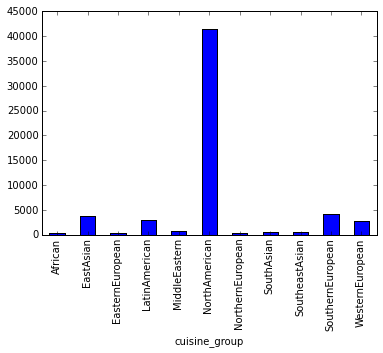

In [38]:
print len(df.cuisine_group)
##Examine the cuisine groups. 
#print df.cuisine_group.value_counts().apply(lambda x : 100*x/float(x.sum()))
print df.groupby('cuisine_group').count().apply(lambda x : 100*x/float(x.sum()))
df.groupby('cuisine_group')['cuisine'].count().plot(kind='bar')

Clearly no suprise there. As most of the recipes came from American Magazines,North American cuisine is defintely overreprested as compared to the other regions, followed by Southern European and others. 

##Vectorization
The features in this data set are the ingredients of the dish themselves.Each ingredient specific to that dish becomes a feature of that dish and hence the cuisine.Since this is text, we use a count vectorizer to do that. Now in this case since an ingredient will either occur or not in a dish ,this fits the Boolean Occurence model of the Bag of Words model. The appropriate vectorizer to choose in this case would be the Binary Vectorizer..essentially setting the binary property of CountVectorizer to true.
Once we vectorize using a binary vectorizer, we build a document term matrix using the ingredients of each recipe as the document. 

In [14]:
# Create a TFIDF vectorizer
count_vect = CountVectorizer(decode_error = 'ignore', binary=True)
# Call fit to do our frequency vectorization
df_dtm =  count_vect.fit_transform(df.ingredients)
print df_dtm.toarray(),count_vect.get_feature_names()

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] [u'almond', u'angelica', u'anise', u'anise_seed', u'apple', u'apple_brandy', u'apricot', u'armagnac', u'artemisia', u'artichoke', u'asparagus', u'avocado', u'bacon', u'baked_potato', u'balm', u'banana', u'barley', u'bartlett_pear', u'basil', u'bay', u'bean', u'beech', u'beef', u'beef_broth', u'beef_liver', u'beer', u'beet', u'bell_pepper', u'bergamot', u'berry', u'bitter_orange', u'black_bean', u'black_currant', u'black_mustard_seed_oil', u'black_pepper', u'black_raspberry', u'black_sesame_seed', u'black_tea', u'blackberry', u'blackberry_brandy', u'blue_cheese', u'blueberry', u'bone_oil', u'bourbon_whiskey', u'brandy', u'brassica', u'bread', u'broccoli', u'brown_rice', u'brussels_sprout', u'buckwheat', u'butter', u'buttermilk', u'cabbage', u'cabernet_sauvignon_wine', u'cacao', u'camembert_cheese', u'cane_molasses', u'caraway', u'cardamom', u'carnation', u'caro

####TBD - Look for patterns such as what ingredients occur most across all cuisines, across each cuisine, whats most rarest among all cuisines, among each cuisine. Types of meats and other specific ingredients across each cuisine

### Lets fit some models.   - Round 1 - Stick to Standard Text Classification Algorithms

In [15]:
##Before any thing, lets split the entire data set into training and test. 
# Split the data into a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(df.ingredients, df.cuisine_group, test_size=0.3)
unique_cuisine_group = df.cuisine_group.unique().tolist()
##For us to be able to use any of the prediction models we need turn the cuisine groups from earlier into numerical labels.
## We use the standard Label Encoder to this.
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
le.fit(unique_cuisine_group)
y_train =  le.transform(y_train)
y_test =  le.transform(y_test)
le.classes_

array(['African', 'EastAsian', 'EasternEuropean', 'LatinAmerican',
       'MiddleEastern', 'NorthAmerican', 'NorthernEuropean', 'SouthAsian',
       'SoutheastAsian', 'SouthernEuropean', 'WesternEuropean'], 
      dtype='|S16')

In [16]:
##Build the Document Term Matrix based on the vectorizer that was created earler. 
train_simple_dtm = count_vect.transform(X_train)
test_simple_dtm = count_vect.transform(X_test)

##Given that we have a set of feature vectors that have a binary occurence probability in a certain dish/document, we 
#look at the naive bayseien model as our initial model. 
# Create the model
bnb = BernoulliNB()
# Fit the model to the training data
bnb.fit(train_simple_dtm, y_train)
# Score the model against the test data
bnb.score(test_simple_dtm, y_test)

0.70776519528541715

So a simple Bernoulli Naive Bayes model with no frills is able to predict with about 71.1% accuracy on our test data set. 

###Set up a pipeline for vectorization , transformation and classification
classfication with a Multinomial Bayesian classifier while also looking building a TF-IDF Transformer


I use a stratified K fold classifier to ensure I have equally weighted sample of different classes in my train and test samples. I do this because as I showed earlier I have lop-sided percentage of various types of my cuisine groups in my data set. 
Similarly I set up a pipe line to build a document term matrix for each train sample using a binary vectorizer with a TF-IDF document transformer.

Similarly I use a simple accuracy score function to measure the accuracy of the prediction. I also set up methods to generate a confusion matrix and plotting of a confusion matrix for on hand later.

###QQQ - Is a simple accuracy score a good measure of accuracy in this case, or should I also weight the accuracy based on the class i.e. use f1-score with average = weighted ??


In [17]:
from  sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self


def plot_confusion_matrix(cm, df,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df.cuisine_group))
    plt.xticks(tick_marks, df.cuisine_group, rotation=45)
    plt.yticks(tick_marks, df.cuisine_group)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
def compute_cm(y_test,y_pred,df):
    cm = confusion_matrix(test_y,predictions)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm,data)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plot_confusion_matrix(cm_normalized,data, title='Normalized confusion matrix')
    

    
def kfold_pipeline_classifier(pipeline,data):
    #sss = cross_validation.StratifiedShuffleSplit(le.transform(data.cuisine_group),test_size =0.3,random_state=42)
    sss = cross_validation.StratifiedKFold(le.transform(data.cuisine_group),n_folds=6,shuffle=True,random_state=42)
    scores = []
    confusion = np.array([[0, 0], [0, 0]])
    for train_indices, test_indices in sss:
        train_text = data.iloc[train_indices]['ingredients'].values
        train_y = le.transform(data.iloc[train_indices]['cuisine_group'].values)
        test_text = data.iloc[test_indices]['ingredients'].values
        test_y = le.transform(data.iloc[test_indices]['cuisine_group'].values)
        pipeline.fit(train_text, train_y)
        predictions = pipeline.predict(test_text)
        #score = f1_score(test_y, predictions, average='weighted') 
        score =accuracy_score(test_y,predictions)
        scores.append(score)
    return scores


In [18]:
bernouli_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('clf',BernoulliNB())])
scores = kfold_pipeline_classifier(bernouli_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with BernoulliNB %.4f" % np.mean(scores)


Cross Validation Scores 
[0.70491632886394351, 0.70763152422541065, 0.70576003327095027, 0.70782192635739549, 0.7104058272632674, 0.70322580645161292]
 Mean accuracy with BernoulliNB 0.7066


In [19]:
multinomial_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('clf',MultinomialNB())])

scores = kfold_pipeline_classifier(multinomial_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with MultinomialNB %.4f" % np.mean(scores)



Cross Validation Scores 
[0.76967051242074624, 0.77573300062383033, 0.77521314202536906, 0.77366340753068441, 0.77273673257023934, 0.7734651404786681]
 Mean accuracy with MultinomialNB 0.7734


While we are at it, lets also look at the commonly used classifiers for text classification before moving to feature engineering or grid searches for optimal parameters.

In [20]:
guassian_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('clf',GaussianNB())])

scores = kfold_pipeline_classifier(guassian_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with GaussianNB %.4f" % np.mean(scores)



Cross Validation Scores 
[0.061843883172227422, 0.060095653982116866, 0.064150551050114371, 0.060120657374661948, 0.060874089490114462, 0.05442247658688866]
 Mean accuracy with GaussianNB 0.0603


###Logistic Regression 
Another workhorse model of text classification ,trying the Logistic regression for multi class set up case.

In [21]:
logistic_regr_pipeline_l2 = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('clf',LogisticRegression(multi_class='ovr',random_state=42,penalty='l2', tol=.01,C=1e5))])

scores = kfold_pipeline_classifier(logistic_regr_pipeline_l2,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Logistic regression %.4f" % np.mean(scores)

Cross Validation Scores 
[0.78318262134913208, 0.78800166354751511, 0.78966521106259102, 0.78884959434158519, 0.78886576482830384, 0.78688865764828309]
 Mean accuracy with Logistic regression 0.7876


In [22]:
logistic_regr_pipeline_l1 = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('clf',LogisticRegression(multi_class='ovr',random_state=42,penalty='l1', tol=.01,C=1e5))])

scores = kfold_pipeline_classifier(logistic_regr_pipeline_l1,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Logistic regression %.4f" % np.mean(scores)

Cross Validation Scores 
[0.78339049994803034, 0.78820960698689957, 0.78987315450197548, 0.78812148949448724, 0.78938605619146718, 0.78813735691987508]
 Mean accuracy with Logistic regression 0.7879


### Support Vector Classifiers.
So we achived a 75.5% accuracy on the model with the Multinomial NB and about 76.7% with the Logistic Regression for multi class classification. Lets see if we can do better with a more sophisticated algorithm such a support vector machines which is generally regarded as on of the best text classification algorithms. These are specially effective in high dimensional space as is the case here. Running the standard SVM classifiers to see the prediction scores.

In [23]:
sgd_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    ('clf',SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

scores = kfold_pipeline_classifier(sgd_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with SGDClassifier %.4f" % np.mean(scores)

Cross Validation Scores 
[0.75584658559401308, 0.75836972343522557, 0.75629028904138074, 0.75473268150613693, 0.75941727367325706, 0.75796045785639954]
 Mean accuracy with SGDClassifier 0.7571


In [24]:
linear_svc_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    ('clf',LinearSVC(penalty='l2',tol=.01,C=1e5,multi_class='ovr'))])

scores = kfold_pipeline_classifier(linear_svc_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Linear SVC %.4f" % np.mean(scores)

Cross Validation Scores 
[0.76145930776426562, 0.74370971095861926, 0.72894572676232061, 0.74880382775119614, 0.53673257023933407, 0.76035379812695114]
 Mean accuracy with Linear SVC 0.7133


###Initial GridSearch with MultinomialNB 

In [25]:
print "Fitting the classifier to the training set"
t0 = time()
# Create GridSearchCV
pipeline = Pipeline(
    [('vec', CountVectorizer(encoding='cp874', decode_error='ignore', binary=True)), ('tfidf', TfidfTransformer(sublinear_tf=True,use_idf=True,)),
     ('clf', MultinomialNB())])
parameters = {
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in {0}s".format(time() - t0))
print("Best score: {0}".format(grid_search.best_score_))
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(parameters.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))


Fitting the classifier to the training set
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  36 | elapsed:   11.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   12.5s finished


done in 13.2581779957s
Best score: 0.775276725355
Best parameters set:
	clf__alpha: 0.01
	tfidf__norm: l2


###Run a few ensemble classifiers before attempting Feature Engineering

In [26]:
## RandomForest Classifier

rf_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    ('clf',RandomForestClassifier())])

scores = kfold_pipeline_classifier(rf_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Random Forest Classifier %.4f" % np.mean(scores)

Cross Validation Scores 
[0.77143748051138139, 0.77282179247244753, 0.77573300062383033, 0.77584772207197839, 0.77398543184183144, 0.77492195629552552]
 Mean accuracy with Random Forest Classifier 0.7741


In [27]:
dt_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    ('clf',DecisionTreeClassifier(max_depth=10,min_samples_split=1))])

scores = kfold_pipeline_classifier(dt_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Random Forest Classifier %.4f" % np.mean(scores)

Cross Validation Scores 
[0.75480719259952189, 0.75660220420045743, 0.75816177999584111, 0.76242978988974408, 0.7599375650364204, 0.75962539021852238]
 Mean accuracy with Random Forest Classifier 0.7586


In [28]:
## Extra Trees Classifier
et_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    ('clf',ExtraTreesClassifier(n_estimators=10))])

scores = kfold_pipeline_classifier(et_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with Random Forest Classifier %.4f" % np.mean(scores)


Cross Validation Scores 
[0.77268475210477083, 0.77739654813890624, 0.78145144520690368, 0.7791762013729977, 0.77814776274713837, 0.77294484911550465]
 Mean accuracy with Random Forest Classifier 0.7770


In [29]:
df[df.cuisine_group.isnull()].cuisine.unique()

array([], dtype=object)

##Benchmarking Classifiers 

In [30]:
# Import train_test_split
from sklearn.cross_validation import train_test_split
# Split the data into a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(df.ingredients, le.transform(df.cuisine_group), test_size=0.3)

categories = df.cuisine_group.unique().tolist() 

use_hashing = False
select_chi2= True
print_top10 = True
print_cm = True
print_report = True

# split a training set and a test set
#y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', non_negative=True
                                   )
    X_train = vectorizer.transform(X_train)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(X_train)
duration = time() - t0
#print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(X_test)
duration = time() - t0
#print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(categories):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s"
                      % (category, ", ".join(feature_names[top10]))))
        print()

    if print_report:
        print("classification report:")
        print(classification_report(y_test, pred,
                                            target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))





Extracting features from the training data using a sparse vectorizer
n_samples: 40383, n_features: 378
()
Extracting features from the test data using the same vectorizer
n_samples: 17308, n_features: 378
()
Extracting 1 best features by a chi-squared test
done in 0.047420s
()
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
train time: 0.046s
test time:  0.003s
accuracy:   0.739
dimensionality: 1
density: 1.000000
top 10 keywords per class:
SoutheastAsian: sesame_oil
SouthAsian: sesame_oil
SouthernEuropean: sesame_oil
MiddleEastern: sesame_oil
WesternEuropean: sesame_oil
LatinAmerican: sesame_oil
NorthAmerican: sesame_oil
NorthernEuropean: sesame_oil
African: sesame_oil
EasternEuropean: sesame_oil
EastAsian: sesame_oil
()
classification report:
                  precision    recall  f

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)



accuracy:   0.737
classification report:
                  precision    recall  f1-score   support

  SoutheastAsian       0.00      0.00      0.00       111
      SouthAsian       0.81      0.29      0.43      1134
SouthernEuropean       0.00      0.00      0.00        95
   MiddleEastern       0.00      0.00      0.00       849
 WesternEuropean       0.00      0.00      0.00       190
   LatinAmerican       0.74      0.99      0.85     12499
   NorthAmerican       0.00      0.00      0.00        71
NorthernEuropean       0.00      0.00      0.00       174
         African       0.00      0.00      0.00       143
 EasternEuropean       0.00      0.00      0.00      1243
       EastAsian       0.00      0.00      0.00       799

     avg / total       0.59      0.74      0.64     17308

confusion matrix:
[[    0     0     0     0     0   111     0     0     0     0     0]
 [    0   332     0     0     0   787     0     0    14     0     1]
 [    0     0     0     0     0    95     0  

//anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


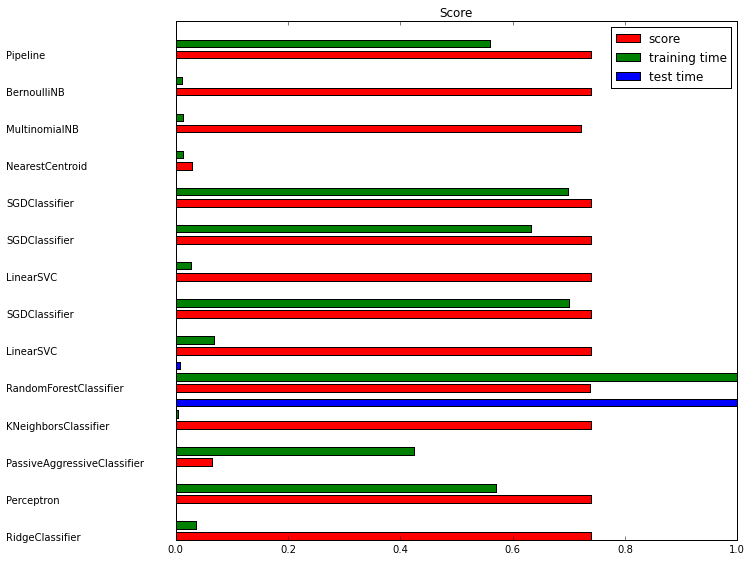

In [31]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

## Feature Engineering 

In [32]:
logr_pca_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                     ('reduce_dim',PCA(copy=True,n_components=50,whiten=False)),        
                     ('clf',LogisticRegression(multi_class='ovr',random_state=42,penalty='l1', tol=.01,C=1e5))])
scores = kfold_pipeline_classifier(logr_pca_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with PCA + Logistic Regression t Classifier %.4f" % np.mean(scores)

Cross Validation Scores 
[0.76665627273672177, 0.77084632979829482, 0.7675192347681431, 0.76919076346993964, 0.77023933402705513, 0.76982310093652451]
 Mean accuracy with PCA + Logistic Regression t Classifier 0.7690


In [33]:
mnb_pca_pipeline = Pipeline([('vect',CountVectorizer(decode_error = 'ignore', binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('to_dense', DenseTransformer()),
                    # ('reduce_dim',PCA(copy=True,n_components=10,whiten=False)),        
                     ('clf',MultinomialNB(alpha=0.01))])
scores = kfold_pipeline_classifier(mnb_pca_pipeline,df)
print "Cross Validation Scores "
print scores
print " Mean accuracy with PCA + Multinomial NB Regression t Classifier %.4f" % np.mean(scores)

Cross Validation Scores 
[0.77258081280532165, 0.77739654813890624, 0.77708463297982944, 0.77397545246515498, 0.77471383975026009, 0.77471383975026009]
 Mean accuracy with PCA + Multinomial NB Regression t Classifier 0.7751
